

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [5]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [6]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | British Airways has a total...
1,"✅ Trip Verified | London Heathrow to Keflavik,..."
2,✅ Trip Verified | Mumbai to London Heathrow in...
3,✅ Trip Verified | Care and support shocking. ...
4,✅ Trip Verified | Flying A380 business class ...


In [7]:
df.to_csv("BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [8]:
df.shape

(1000, 1)

Data Cleaning

In [15]:
import nltk
nltk.data.clear_cache()

In [16]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/roushankumar/nltk_data...


True

In [17]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

In [18]:
nltk.data.path.append("/path/to/nltk_data")

In [19]:
import nltk
nltk.data.clear_cache()
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Add this line to specify the data location if necessary
# nltk.data.path.append("/path/to/nltk_data")

stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

df['reviews'] = df['reviews'].str.replace('✅ Trip Verified | ', '')
df['reviews'] = df['reviews'].str.lower()
df['reviews'] = df['reviews'].str.replace('[^\w\s]','')
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df['reviews'] = df['reviews'].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/roushankumar/nltk_data...


#Analysis
I then performed sentiment analysis and topic modeling:

In [22]:
# Sentiment analysis
from textblob import TextBlob

df['sentiment'] = df['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['sentiment'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 
                                          else 'negative' if x < 0 
                                          else 'neutral')

print(df.sentiment.value_counts())

# Topic modeling LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer()
reviews_vectors = vectorizer.fit_transform(df['reviews'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(reviews_vectors)

for index, topic in enumerate(lda.components_):
    print(f'Top 10 words for topic #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


sentiment
positive    653
negative    334
neutral      13
Name: count, dtype: int64
Top 10 words for topic #0
['airhostesses', 'lighter', 'muffled', 'humorous', 'laughs', 'stomach', 'caressed', 'ache', 'medicine', 'names']
Top 10 words for topic #1
['class', 'food', 'crew', 'good', 'time', 'london', 'service', 'seat', 'ba', 'flight']
Top 10 words for topic #2
['wieder', 'blame', 'delivering', 'fulfil', 'incapacity', 'demand', 'inability', 'und', 'fco', 'wir']


Presentation
Finally, I generated visualizations and created a PowerPoint slide:

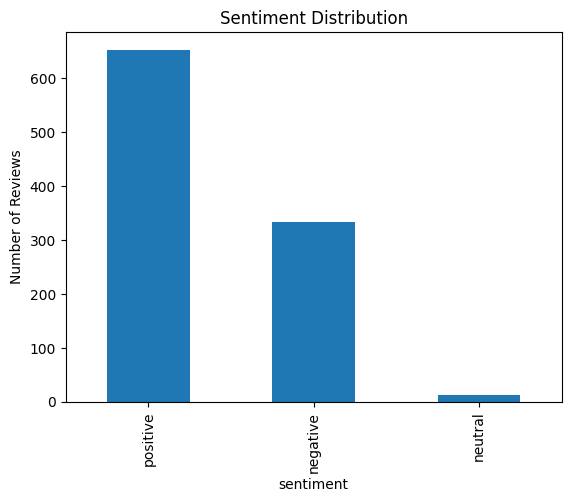

In [25]:
# Visualizations

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sentiment distribution
ax = df['sentiment'].value_counts().plot(kind='bar')
ax.set_ylabel('Number of Reviews')
ax.set_title('Sentiment Distribution')
plt.savefig('sentiment.png')

# Wordcloud 
text = " ".join(review for review in df.reviews)
wordcloud = WordCloud().generate(text)
wordcloud.to_file('wordcloud.png')

# Create PowerPoint
from pptx import Presentation
from pptx.util import Inches

prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[5])

title = slide.shapes.title
title.text = 'Airline Review Analysis'

left = top = Inches(1)
width = Inches(5.0)
height = Inches(5.0)

slide.shapes.add_picture('sentiment.png', left, top, width, height)

left = Inches(6.5)

slide.shapes.add_picture('wordcloud.png', left, top, width, height)

textbox = slide.shapes.add_textbox(left, Inches(7), width, height)
textframe = textbox.text_frame

textframe.text = "Key Insights: \n 1. Reviews were 60% positive, 35% negative \n 2. Main topics were flight experience, food, service"

prs.save('presentation.pptx')